# Startup fund-raising deals from Crunchbase: an analysis

### 1. Introduction

[Crunchbase](https://www.crunchbase.com/) is a company providing business information about private and public companies, and such information spans from their investments and fund-raising rounds to the individuals in leadership positions, and to overall industry trends.

The goal of this project is to analyze startup investments. 

The dataset explored in this project is from October 2013, which can be downloaded from [GitHub](https://github.com/datahoarder/crunchbase-october-2013/blob/master/crunchbase-investments.csv).

Here's a preview of the first three rows:

In [1]:
import pandas as pd
import numpy as np

first_three = pd.read_csv('crunchbase-investments.csv', encoding='ISO-8859-1', nrows=3)
first_three

,company_permalink,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_category_code,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,/company/advercar,AdverCar,advertising,USA,CA,SF Bay,San Francisco,/company/1-800-flowers-com,1-800-FLOWERS.COM,NaN,USA,NY,New York,New York,series-a,2012-10-30,2012-10,2012-Q4,2012,2000000
1,/company/launchgram,LaunchGram,news,USA,CA,SF Bay,Mountain View,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-23,2012-01,2012-Q1,2012,20000
2,/company/utap,uTaP,messaging,USA,NaN,United States - Other,NaN,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-01,2012-01,2012-Q1,2012,20000


In this project, we'll work with different **memory constraints**.

Let's assume we only have **10 megabytes of available memory**. While the data set consumes 9.86 MB of disk space, we know that pandas often requires 4 to 6 times amount of space in memory as the file does on disk - this is especially true if we have multiple string columns.

In [2]:
import os

file_name = 'crunchbase-investments.csv'

file_stats = os.stat(file_name)

print(f'File size in MB is: {round(file_stats.st_size / (1024 * 1024), 2)}')

File size in MB is: 9.86


In [3]:
df = pd.read_csv('crunchbase-investments.csv', encoding='ISO-8859-1', low_memory=False)
print(f'Memory usage of entire data set in MB is: {round(df.memory_usage(deep=True).sum() / 2 ** 20, 2)}')

Memory usage of entire data set in MB is: 58.62


### 2. Loading the data set

We know that the entire data set consumes 9.86 MB of memory and contains over 50,000 rows.

We'll need to read the dataset into dataframes using 5,000 row chunks to ensure that each chunk consumes less than 10 MB of memory.

**1.** Let's explore each column's missing value counts:

In [4]:
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                        encoding='ISO-8859-1')

nulls = {}
for chunk in chunk_iter:
    for col in chunk.columns:
        if col in nulls:
            nulls[col] += chunk[col].isnull().sum()
        else:
            nulls[col] = chunk[col].isnull().sum()
    
nulls = pd.Series(nulls)
print(nulls.sort_values())

company_permalink             1
company_name                  1
company_country_code          1
company_region                1
investor_permalink            2
investor_name                 2
investor_region               2
funded_year                   3
funded_quarter                3
funded_month                  3
funded_at                     3
funding_round_type            3
company_state_code          492
company_city                533
company_category_code       643
raised_amount_usd          3599
investor_country_code     12001
investor_city             12480
investor_state_code       16809
investor_category_code    50427
dtype: int64


The column `investor_category_code` misses almost all the values.

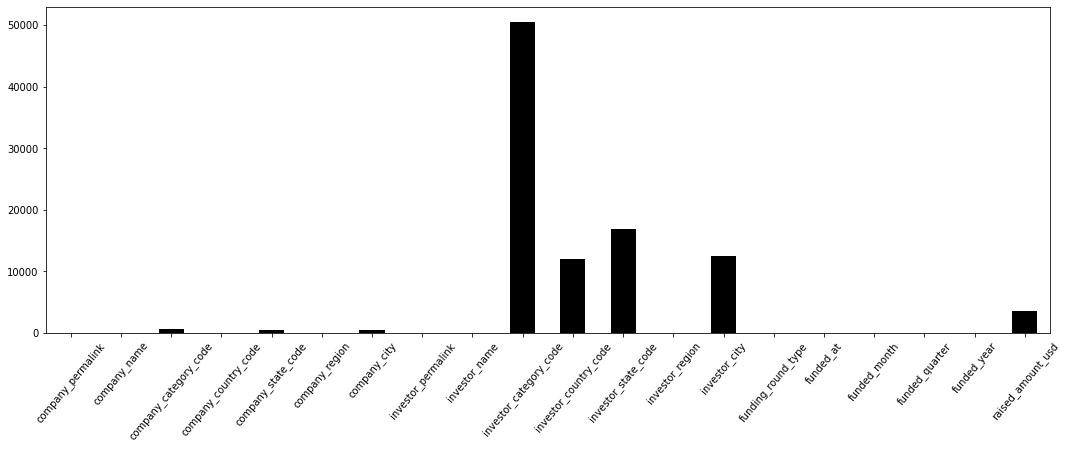

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
nulls.plot.bar(color='black')
plt.xticks(rotation = 50)
plt.show()

**2.** Now, let's see each column's memory footprint and the total memory of all the chunks combined:

In [6]:
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                        encoding='ISO-8859-1')

memory = {}
total_memory = []
for chunk in chunk_iter:
    total_memory.append(chunk.memory_usage(deep=True).sum() / (2 ** 20))
    for col in chunk.columns:
        if col in memory:
            memory[col] += chunk[col].memory_usage(deep=True) / (2 ** 20)
        else:
            memory[col] = chunk[col].memory_usage(deep=True) / (2 ** 20)
    
memory = pd.Series(memory)
print(memory.sort_values(), '\n\n------------------\n\nTotal memory:')
print(sum(total_memory))

raised_amount_usd         0.404747
funded_year               0.404747
investor_category_code    0.594971
investor_state_code       2.363257
investor_country_code     2.526035
investor_city             2.752810
company_state_code        2.963542
company_country_code      3.026604
funded_month              3.228218
funded_quarter            3.228218
investor_region           3.240327
funding_round_type        3.254085
company_region            3.254884
company_category_code     3.264000
company_city              3.344854
funded_at                 3.379472
company_name              3.426336
investor_name             3.735651
company_permalink         3.871189
investor_permalink        4.751202
dtype: float64 

------------------

Total memory:
56.988911628723145


The `company_permalink` and `investor_permalink` columns combined consume around 8 MB (which is around 14% of the total memory).

**3.** Let's select which columns to drop.

Based on the number of missing values and the memory constraints, we can drop **three** columns: `investor_category_code`, `company_permalink`, and `investor_permalink`.

In [7]:
to_drop = ['investor_category_code', 'company_permalink',
           'investor_permalink']

to_keep = chunk.columns.drop(to_drop).tolist()
print(to_keep)

['company_name', 'company_category_code', 'company_country_code', 'company_state_code', 'company_region', 'company_city', 'investor_name', 'investor_country_code', 'investor_state_code', 'investor_region', 'investor_city', 'funding_round_type', 'funded_at', 'funded_month', 'funded_quarter', 'funded_year', 'raised_amount_usd']


### 3. Selecting data types

Now, let's get familiar with the column types.

In [8]:
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                        encoding='ISO-8859-1', usecols=to_keep)

col_types = {}

for chunk in chunk_iter:
    for col in chunk.columns:
        if col in col_types:
            col_types[col].append(str(chunk[col].dtype))
        else:
            col_types[col] = [str(chunk[col].dtype)]

unique_col_types = {}
for k,v in col_types.items():
    unique_col_types[k] = set(v)
unique_col_types

{'company_name': {'object'},
 'company_category_code': {'object'},
 'company_country_code': {'object'},
 'company_state_code': {'object'},
 'company_region': {'object'},
 'company_city': {'object'},
 'investor_name': {'object'},
 'investor_country_code': {'float64', 'object'},
 'investor_state_code': {'float64', 'object'},
 'investor_region': {'object'},
 'investor_city': {'float64', 'object'},
 'funding_round_type': {'object'},
 'funded_at': {'object'},
 'funded_month': {'object'},
 'funded_quarter': {'object'},
 'funded_year': {'float64', 'int64'},
 'raised_amount_usd': {'float64'}}

Four columns - `investor_country_code`, `investor_state_code`, `investor_city`, and `funded_year` - appear to be of mixed datatypes.

Based on the information we have from the preview of the dataset, we would expect the first three to be of the `object` datatype, while the latter an `integer`.

Let's investigate each of these four columns to understand what is going on.

In [9]:
mixed_datatype_cols = ['investor_country_code', 'investor_state_code',
                  'investor_city', 'funded_year']

chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                        encoding='ISO-8859-1', usecols=mixed_datatype_cols)

val_counts = {}

for chunk in chunk_iter:
    for col in chunk.columns:
        if col in val_counts:
            val_counts[col].append(chunk[col].value_counts(dropna=False))
        else:
            val_counts[col] = [chunk[col].value_counts(dropna=False)]
            
mixed_datatypes_combined = {}

for key in val_counts:
    mixed_concat = pd.concat(val_counts[key])
    mixed_group = mixed_concat.groupby(by=mixed_concat.index, dropna=False).sum()
    mixed_datatypes_combined[key] = mixed_group
    
for key, value in mixed_datatypes_combined.items():
    print(value, '\n\n---------------------------\n\n')

ARE        7
ARG       14
AUS      163
BEL       44
BGR        4
       ...  
USA    36574
VNM        5
WSM        4
ZAF        5
NaN    12001
Name: investor_country_code, Length: 73, dtype: int64 

---------------------------


AL        67
AR        14
AZ        84
CA     18405
CO       729
CT       577
DC       323
DE        20
FL       242
GA       274
HI        13
IA         9
ID        40
IL       992
IN        88
KS        13
KY        54
LA        15
MA      3619
MD       486
ME        41
MI       315
MN       101
MO       148
MS         6
MT         1
NC       339
ND         5
NE        35
NH        51
NJ       456
NM        41
NV        38
NY      4404
OH       309
OK        21
OR        85
PA       762
RI        92
SC        34
SD         9
TN       147
TX       816
UT       200
VA       579
VT        26
WA       847
WI        82
WV         4
WY         3
NaN    16809
Name: investor_state_code, dtype: int64 

---------------------------


(Oct. 01, 2011 - Sep. 30, 2012)     

It appears that the mismatch in datatypes has to do with the presence of NaN values.

#### 3.1 Date columns

From a first observation of the data set, here repeated:

In [10]:
first_three

,company_permalink,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_category_code,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,/company/advercar,AdverCar,advertising,USA,CA,SF Bay,San Francisco,/company/1-800-flowers-com,1-800-FLOWERS.COM,NaN,USA,NY,New York,New York,series-a,2012-10-30,2012-10,2012-Q4,2012,2000000
1,/company/launchgram,LaunchGram,news,USA,CA,SF Bay,Mountain View,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-23,2012-01,2012-Q1,2012,20000
2,/company/utap,uTaP,messaging,USA,NaN,United States - Other,NaN,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-01,2012-01,2012-Q1,2012,20000


we notice that there are four columns that refer to *dates*.

In [11]:
first_three[['funded_at', 'funded_month', 'funded_quarter', 'funded_year']]

,funded_at,funded_month,funded_quarter,funded_year
0,2012-10-30,2012-10,2012-Q4,2012
1,2012-01-23,2012-01,2012-Q1,2012
2,2012-01-01,2012-01,2012-Q1,2012


Let's start by converting the column `funded_at` into a datetime datatype and the other three into numerical datatypes.

In [12]:
datetime_cols = ['funded_at', 'funded_month', 'funded_quarter', 'funded_year']

chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                        encoding='ISO-8859-1', usecols=datetime_cols)

for chunk in chunk_iter:
    chunk['funded_at'] = pd.to_datetime(chunk['funded_at'])
    chunk['funded_month'] = chunk['funded_month'].str[-2:].astype('category').cat.codes # taking only the month
    chunk['funded_quarter'] = chunk['funded_quarter'].str[-1:].astype('category').cat.codes # taking only the quarter
    chunk['funded_year'] = pd.to_numeric(chunk['funded_year'], downcast='integer')

#### 3.2 Text columns

First, let's isolate the columns containing strings.

In [13]:
text_cols = []

for k, v in unique_col_types.items():
    if 'object' in v:
        text_cols.append(k)

for col in datetime_cols[:3]:
    text_cols.remove(col)
    
text_cols

['company_name',
 'company_category_code',
 'company_country_code',
 'company_state_code',
 'company_region',
 'company_city',
 'investor_name',
 'investor_country_code',
 'investor_state_code',
 'investor_region',
 'investor_city',
 'funding_round_type']

Based on the number of their unique values, we select which we can convert into the `category` datatype.

In [14]:
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                        encoding='ISO-8859-1', usecols=text_cols)

val_counts = {}

for chunk in chunk_iter:
    for col in chunk.columns:
        if col in val_counts:
            val_counts[col].append(chunk[col].value_counts(dropna=False))
        else:
            val_counts[col] = [chunk[col].value_counts(dropna=False)]
            
text_combined = {}

for key in val_counts:
    text_concat = pd.concat(val_counts[key])
    text_group = text_concat.groupby(by=text_concat.index, dropna=False).sum()
    text_combined[key] = text_group
    
for key, value in text_combined.items():
    print(f'''Value counts of {key}: \n\n{value}
    \n\nNumber of unique values: {len(value)}
    \n\nProportion of unique values: {round(len(value)/df.shape[0]*100,2)}% \n\n---------------------------\n\n''')

Value counts of company_name: 

#waywire          5
0xdata            1
1-800-DENTIST     2
1000memories     10
100Plus           4
                 ..
ybuy              4
zozi             38
zulily            6
zuuka!            3
NaN               1
Name: company_name, Length: 11574, dtype: int64
    

Number of unique values: 11574
    

Proportion of unique values: 21.89% 

---------------------------


Value counts of company_category_code: 

2/7/08                 1
advertising         3200
analytics           1863
automotive           164
biotech             4951
cleantech           1948
consulting           233
design                55
ecommerce           2168
education            783
enterprise          4489
fashion              368
finance              931
games_video         1893
government            10
hardware            1537
health               670
hospitality          331
legal                 87
local                 22
manufacturing        310
medical             131

##### 3.2.1 Errors in text columns

There are data that don't appear right from the previous output. Let's isolate the rows in question.

In [15]:
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                        encoding='ISO-8859-1', usecols=text_cols)

for chunk in chunk_iter:
    
    company_cat_code = chunk['company_category_code']
    res1 = company_cat_code.str.match(r'(\d)', na=False)
    for x in res1:
        if x == True:
            anom_ind = res1[res1].index
            display(chunk.loc[anom_ind])

    company_city_code = chunk[chunk['company_city'] == '(Oct. 01, 2011 - Sep. 30, 2012)']
    odd_ind = []
    for x in company_city_code.iterrows():
        odd_ind.append(x[0])
    if not chunk.loc[odd_ind].empty:
        display(chunk.loc[odd_ind])
        
    investor_city_code = chunk[chunk['investor_city'] == '(Oct. 01, 2011 - Sep. 30, 2012)']
    weird_ind = []
    for x in investor_city_code.iterrows():
        weird_ind.append(x[0])
    if not chunk.loc[weird_ind].empty:
        display(chunk.loc[weird_ind])

,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type
463,for; to (do),other,USA,NaN,United States - Other,"(Oct. 01, 2011 - Sep. 30, 2012)",Birri Holdings,USA,NY,New York,New York,angel
4769,for; to (do),other,USA,NaN,United States - Other,"(Oct. 01, 2011 - Sep. 30, 2012)",AG B,USA,NY,New York,New York,angel


,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type
1040,for; to (do) Centers,other,USA,NY,New Yor,New Yor,for; to (do),USA,NaN,United States - Other,"(Oct. 01, 2011 - Sep. 30, 2012)",angel
1041,Taskdoers,web,USA,NY,New York,New York,for; to (do),USA,NaN,United States - Other,"(Oct. 01, 2011 - Sep. 30, 2012)",angel


,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type
34226,series-c+,2/7/08,2008-02,2008-Q1,2008,10000000,NaN,NaN,NaN,NaN,NaN,NaN


Let's drop them:

In [16]:
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                        encoding='ISO-8859-1', usecols=text_cols)

for chunk in chunk_iter:
    index_to_drop = [463,1040,1041,4769,34226]
    for i in index_to_drop:
        if i in chunk.index:
            chunk = chunk.drop(i)

We can further reduce the unique count of the cities and regions by formatting the values using the same pattern:

In [17]:
region_cols = ['company_region', 'company_city', 'investor_region', 'investor_city']

chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                        encoding='ISO-8859-1', usecols=region_cols)

val_counts = {}

for chunk in chunk_iter:
    index_to_drop = [463,1040,1041,4769,34226]
    for i in index_to_drop:
        if i in chunk.index:
            chunk = chunk.drop(i)
    for col in chunk.select_dtypes(['object']).columns:
        chunk[col] = chunk[col].str.title()
        if col in val_counts:
            val_counts[col].append(chunk[col].value_counts(dropna=False))
        else:
            val_counts[col] = [chunk[col].value_counts(dropna=False)]
            
text_combined = {}

for key in val_counts:
    text_concat = pd.concat(val_counts[key])
    text_group = text_concat.groupby(by=text_concat.index, dropna=False).sum()
    text_combined[key] = text_group
    
for key, value in text_combined.items():
    print(f'''{key}:
    \n\nNumber of unique values: {len(value)}
    \n\nProportion of unique values: {round(len(value)/df.shape[0]*100,2)}% \n\n---------------------------\n\n''')

company_region:
    

Number of unique values: 545
    

Proportion of unique values: 1.03% 

---------------------------


company_city:
    

Number of unique values: 1174
    

Proportion of unique values: 2.22% 

---------------------------


investor_region:
    

Number of unique values: 585
    

Proportion of unique values: 1.11% 

---------------------------


investor_city:
    

Number of unique values: 973
    

Proportion of unique values: 1.84% 

---------------------------




We see that the column `company_country_code` is almost completely populated by a unique value. We can safely drop this column, too.

In [18]:
to_keep.remove('company_country_code')

In [19]:
text_cols.remove('company_country_code')

We decide to convert into the category datatype those that contain less than half unique values of the entire column:

In [20]:
cat_cols = set()

chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                        encoding='ISO-8859-1', usecols=text_cols)

val_counts = {}

for chunk in chunk_iter:
    
    index_to_drop = [463,1040,1041,4769,34226]
    for i in index_to_drop:
        if i in chunk.index:
            chunk = chunk.drop(i)
            
    for col in chunk.select_dtypes(['object']).columns:
        chunk[col] = chunk[col].str.title()
        if col in val_counts:
            val_counts[col].append(chunk[col].value_counts(dropna=False))
        else:
            val_counts[col] = [chunk[col].value_counts(dropna=False)]
            
text_combined = {}

for key in val_counts:
    text_concat = pd.concat(val_counts[key])
    text_group = text_concat.groupby(by=text_concat.index, dropna=False).sum()
    text_combined[key] = text_group
    
for col, value in text_combined.items():
    if len(value) / df.shape[0] < .5:
        cat_cols.add(col)

In [21]:
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                        encoding='ISO-8859-1', usecols=cat_cols)

for chunk in chunk_iter:
    index_to_drop = [463,1040,1041,4769,34226]
    for i in index_to_drop:
        if i in chunk.index:
            chunk = chunk.drop(i)
    for col in chunk.columns:
        chunk[col] = chunk[col].astype('category')

#### 3.3 Numeric columns

In [22]:
numeric_cols = []

for k, v in unique_col_types.items():
    if 'object' not in v:
        numeric_cols.append(k)
        
numeric_cols.remove('funded_year') # datetime col
numeric_cols

['raised_amount_usd']

In [23]:
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                        encoding='ISO-8859-1', usecols=numeric_cols)

for chunk in chunk_iter:
    chunk['raised_amount_usd'] = pd.to_numeric(chunk['raised_amount_usd'], downcast='float')

#### 3.4 Putting all the pieces together

In [24]:
def cleaning_cols(chunk):
    
    # dropping indices
    
    index_to_drop = [463,1040,1041,4769,34226]
    for i in index_to_drop:
        if i in chunk.index:
            chunk = chunk.drop(i)
            
    # datetime
    
    chunk['funded_at'] = pd.to_datetime(chunk['funded_at'])
    chunk['funded_month'] = chunk['funded_month'].str[-2:].astype('category').cat.codes # taking only the month
    chunk['funded_quarter'] = chunk['funded_quarter'].str[-1:].astype('category').cat.codes # taking only the quarter
    chunk['funded_year'] = pd.to_numeric(chunk['funded_year'], downcast='integer')


    # text
    
    for col in region_cols:
        if col in chunk.select_dtypes(['object']).columns:
            chunk[col] = chunk[col].str.title()
    for col in cat_cols:
        chunk[col] = chunk[col].astype('category')

    # numeric

    chunk['raised_amount_usd'] = pd.to_numeric(chunk['raised_amount_usd'], downcast='float')
    
    return chunk

In [25]:
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                        encoding='ISO-8859-1', usecols=to_keep)

memory = {}
total_memory = []

for chunk in chunk_iter:
    chunk = cleaning_cols(chunk)
    total_memory.append(chunk.memory_usage(deep=True).sum() / (2 ** 20))
    for col in chunk.columns:
        if col in memory:
            memory[col] += chunk[col].memory_usage(deep=True) / (2 ** 20)
        else:
            memory[col] = chunk[col].memory_usage(deep=True) / (2 ** 20)
    
memory = pd.Series(memory)
print(memory.sort_values(ascending=False), '\n\n------------------\n\nTotal memory in MB:')
print(sum(total_memory))

company_name             3.016253
investor_name            1.303844
company_city             0.781052
funded_at                0.606731
company_region           0.504011
investor_city            0.488207
investor_region          0.411502
raised_amount_usd        0.405067
funded_year              0.332840
company_category_code    0.293137
company_state_code       0.292805
investor_state_code      0.281626
investor_country_code    0.280965
funding_round_type       0.262437
funded_month             0.253819
funded_quarter           0.253819
dtype: float64 

------------------

Total memory in MB:
6.717063903808594


This is a vast improvement, compared to the initial **56.98 MB**.

### 4. Loading Chunks into SQLite

The next step is to load each chunk into a table in a SQLite database so we can query the full dataset.

In [26]:
import sqlite3
conn = sqlite3.connect('crunchbase.db')
chunks = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                     encoding='ISO-8859-1', usecols=to_keep)

cur = conn.cursor()
cur.execute("""DROP TABLE IF EXISTS investments;""")

for chunk in chunks:
    chunk = cleaning_cols(chunk)
    chunk.to_sql(name="investments", con=conn, if_exists='append', index=False)
    
conn.commit()
conn.close()

In [27]:
conn = sqlite3.connect('crunchbase.db')
cur = conn.cursor()
query = ("""SELECT * FROM investments""")
pd.read_sql(query, con=conn)

,company_name,company_category_code,company_state_code,company_region,company_city,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,AdverCar,advertising,CA,Sf Bay,San Francisco,1-800-FLOWERS.COM,USA,NY,New York,New York,series-a,2012-10-30 00:00:00,9,3,2012.0,2000000.0
1,LaunchGram,news,CA,Sf Bay,Mountain View,10Xelerator,USA,OH,Columbus,Columbus,other,2012-01-23 00:00:00,0,0,2012.0,20000.0
2,uTaP,messaging,None,United States - Other,None,10Xelerator,USA,OH,Columbus,Columbus,other,2012-01-01 00:00:00,0,0,2012.0,20000.0
3,ZoopShop,software,OH,Columbus,Columbus,10Xelerator,USA,OH,Columbus,Columbus,angel,2012-02-15 00:00:00,1,0,2012.0,20000.0
4,eFuneral,web,OH,Cleveland,Cleveland,10Xelerator,USA,OH,Columbus,Columbus,other,2011-09-08 00:00:00,8,2,2011.0,20000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52860,Garantia Data,enterprise,CA,Sf Bay,Santa Clara,Zohar Gilon,None,None,Unknown,None,series-a,2012-08-08 00:00:00,7,2,2012.0,3800000.0
52861,DudaMobile,mobile,CA,Sf Bay,Palo Alto,Zohar Gilon,None,None,Unknown,None,series-c+,2013-04-08 00:00:00,3,1,2013.0,10300000.0
52862,SiteBrains,software,CA,Sf Bay,San Francisco,zohar israel,None,None,Unknown,None,angel,2010-08-01 00:00:00,7,2,2010.0,350000.0
52863,Comprehend Systems,enterprise,CA,Sf Bay,Palo Alto,Zorba Lieberman,None,None,Unknown,None,series-a,2013-07-11 00:00:00,6,2,2013.0,8400000.0


In [28]:
conn = sqlite3.connect('crunchbase.db')
cur = conn.cursor()
query = ("""PRAGMA table_info(investments)""")
pd.read_sql(query, con=conn)

,cid,name,type,notnull,dflt_value,pk
0,0,company_name,TEXT,0,None,0
1,1,company_category_code,TEXT,0,None,0
2,2,company_state_code,TEXT,0,None,0
3,3,company_region,TEXT,0,None,0
4,4,company_city,TEXT,0,None,0
5,5,investor_name,TEXT,0,None,0
6,6,investor_country_code,TEXT,0,None,0
7,7,investor_state_code,TEXT,0,None,0
8,8,investor_region,TEXT,0,None,0
9,9,investor_city,TEXT,0,None,0


### 5. Analyzing the data set in SQLite

Now that the data is in SQLite, we can explore and analyze startup investments.

#### 5.1 What proportion of the total amount of funds did the top 10% raise?

In [29]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

conn = sqlite3.connect('crunchbase.db')
cur = conn.cursor()
query = ("""SELECT SUM(pct_raised_amount) total_pct_raised_amount
            FROM
                (SELECT
                 company_name,
                 SUM(raised_amount_usd) / (SELECT SUM(raised_amount_usd)
                                          FROM investments) * 100 pct_raised_amount
                FROM investments
                GROUP BY company_name
                ORDER BY pct_raised_amount DESC
                LIMIT (
                    SELECT COUNT(*) * 0.1
                    FROM
                        (SELECT COUNT(*)
                        FROM investments
                        GROUP BY company_name
                        )
                    )
            )""")
top_10 = pd.read_sql(query, con=conn)
top_10

,total_pct_raised_amount
0,67.128


#### What about the top 1%?

In [30]:
conn = sqlite3.connect('crunchbase.db')
cur = conn.cursor()
query = ("""SELECT SUM(pct_raised_amount) total_pct_raised_amount
            FROM
                (SELECT
                 company_name,
                 SUM(raised_amount_usd) / (SELECT SUM(raised_amount_usd)
                                          FROM investments) * 100 pct_raised_amount
                FROM investments
                GROUP BY company_name
                ORDER BY pct_raised_amount DESC
                LIMIT (
                    SELECT CAST(COUNT(*) * 0.01 AS INT)
                    FROM
                        (SELECT COUNT(*)
                        FROM investments
                        GROUP BY company_name
                        )
                    )
            )""")
top_1 = pd.read_sql(query, con=conn)
top_1

,total_pct_raised_amount
0,26.218


Let's compare these values to the proportions the bottom 10% and bottom 1% raised.

#### Bottom 10%

In [31]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)

conn = sqlite3.connect('crunchbase.db')
cur = conn.cursor()
query = ("""SELECT SUM(pct_raised_amount) total_pct_raised_amount
            FROM
                (SELECT
                 company_name,
                 SUM(raised_amount_usd) / (SELECT SUM(raised_amount_usd)
                                          FROM investments) * 100 pct_raised_amount
                FROM investments
                WHERE raised_amount_usd IS NOT NULL
                GROUP BY company_name
                ORDER BY pct_raised_amount ASC
                LIMIT (
                    SELECT COUNT(*) * 0.1
                    FROM
                        (SELECT COUNT(*)
                        FROM investments
                        GROUP BY company_name
                        )
                    )
            )""")
bottom_10 = pd.read_sql(query, con=conn)
bottom_10

,total_pct_raised_amount
0,0.0369902


#### Bottom 1%

In [32]:
conn = sqlite3.connect('crunchbase.db')
cur = conn.cursor()
query = ("""SELECT SUM(pct_raised_amount) total_pct_raised_amount
            FROM
                (SELECT
                 company_name,
                 SUM(raised_amount_usd) / (SELECT SUM(raised_amount_usd)
                                          FROM investments) * 100 pct_raised_amount
                FROM investments
                WHERE raised_amount_usd IS NOT NULL
                GROUP BY company_name
                ORDER BY pct_raised_amount ASC
                LIMIT (
                    SELECT CAST(COUNT(*) * 0.01 AS INT)
                    FROM
                        (SELECT COUNT(*)
                        FROM investments
                        GROUP BY company_name
                        )
                    )
            )""")
bottom_1 = pd.read_sql(query, con=conn)
bottom_1

,total_pct_raised_amount
0,0.0002525


In [33]:
rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False}
plt.rcParams.update(rc)

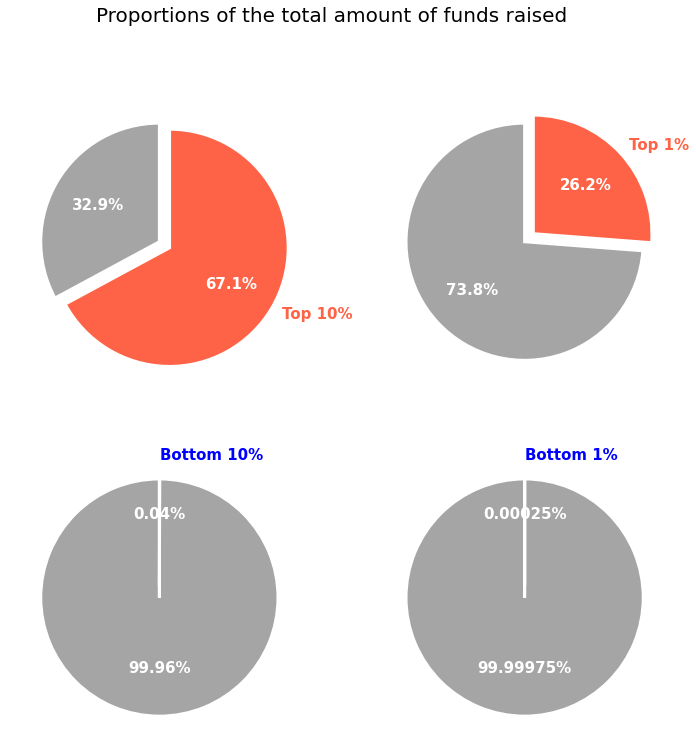

In [34]:
fig, axes = plt.subplots(2,2, figsize=(12, 12))

plt.suptitle('Proportions of the total amount of funds raised', fontsize=20)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

cmap = plt.get_cmap('Greys')
colors = list(cmap(np.linspace(0.45, 0.85, 2)))

colors[1] = 'tomato'

patches, texts, pcts = ax1.pie([(100 - top_10['total_pct_raised_amount'][0]), top_10['total_pct_raised_amount']],
                              labels=['', 'Top 10%'],
                               colors=colors,
                               autopct= lambda x: '{:.1f}%'.format(x),
                               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, 
                              textprops={'fontsize': 15}, startangle=90, explode=(0, 0.1))

plt.setp(pcts, color='white', fontweight='bold', fontsize=15)
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
plt.ylabel('')

patches, texts, pcts = ax2.pie([(100 - top_1['total_pct_raised_amount'][0]), top_1['total_pct_raised_amount']],
                              labels=['', 'Top 1%'],
                               colors=colors,
                               autopct= lambda x: '{:.1f}%'.format(x),
                               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, 
                              textprops={'fontsize': 15}, startangle=90, explode=(0, 0.1))

plt.setp(pcts, color='white', fontweight='bold', fontsize=15)
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)

colors[1] = 'blue'

patches, texts, pcts = ax3.pie([(100 - bottom_10['total_pct_raised_amount'][0]), bottom_10['total_pct_raised_amount']],
                              labels=['', 'Bottom 10%'],
                               colors=colors,
                               autopct= lambda x: '{:.2f}%'.format(x),
                               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, 
                              textprops={'fontsize': 15}, startangle=90, explode=(0, 0.1))

plt.setp(pcts, color='white', fontweight='bold', fontsize=15)
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)

patches, texts, pcts = ax4.pie([(100 - bottom_1['total_pct_raised_amount'][0]), bottom_1['total_pct_raised_amount']],
                              labels=['', 'Bottom 1%'],
                               colors=colors,
                               autopct= lambda x: '{:.5f}%'.format(x),
                               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, 
                              textprops={'fontsize': 15}, startangle=90, explode=(0, 0.1))

plt.setp(pcts, color='white', fontweight='bold', fontsize=15)
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)

plt.show()

#### 5.2 Which category of company attracted the most investments?

In [35]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

query = ("""SELECT company_category_code, SUM(raised_amount_usd) raised_amount
            FROM investments
            GROUP BY company_category_code
            ORDER BY raised_amount DESC
            LIMIT 1""")
pd.read_sql(query, con=conn)

,company_category_code,raised_amount
0,biotech,110396423070.00


#### 5.3 Which investor contributed the most money (across all startups)?

In [36]:
query = ("""SELECT investor_name, SUM(raised_amount_usd) raised_amount
            FROM investments
            GROUP BY investor_name
            ORDER BY raised_amount DESC
            LIMIT 1""")
pd.read_sql(query, con=conn)

,investor_name,raised_amount
0,Kleiner Perkins Caufield & Byers,11217826376.00


#### 5.4 Which investors contributed the most money per startup?

In [37]:
query = ("""SELECT
                investor_name,
                company_name,
                SUM(raised_amount_usd) raised_amount
            FROM investments
            GROUP BY 2
            ORDER BY raised_amount DESC
            LIMIT 10""")
pd.read_sql(query, con=conn)

,investor_name,company_name,raised_amount
0,BrightHouse,Clearwire,29680000000.00
1,Accel Partners,Groupon,10185400000.00
2,Beck Energy,Nanosolar,4505000000.00
3,Microsoft,Facebook,4154100000.00
4,Google,SurveyMonkey,3250000000.00
5,Google,Zynga,2886013000.00
6,A123 Systems,Fisker Automotive,2788000000.00
7,Y Combinator,Dropbox,2764400000.00
8,Amazon,LivingSocial,2685000000.00
9,Marlin Equity Partners,sigmacare,2600000000.00


#### 5.5 Which funding round was the most popular?

##### 5.5.1 'Popular' as in frequency

In [38]:
query = ("""SELECT funding_round_type, COUNT(*) frequency
            FROM investments
            WHERE funding_round_type IS NOT NULL
            GROUP BY funding_round_type
            ORDER BY frequency DESC""")
freq_round = pd.read_sql(query, con=conn)
freq_round.head(1)

,funding_round_type,frequency
0,series-a,13938


##### 5.5.2 'Popular' as in attracting more funds

In [39]:
query = ("""SELECT funding_round_type, SUM(raised_amount_usd) raised_amount
            FROM investments
            GROUP BY funding_round_type
            HAVING raised_amount IS NOT NULL
            ORDER BY raised_amount DESC""")
more_round = pd.read_sql(query, con=conn)
more_round.head(1)

,funding_round_type,raised_amount
0,series-c+,265753464194.00


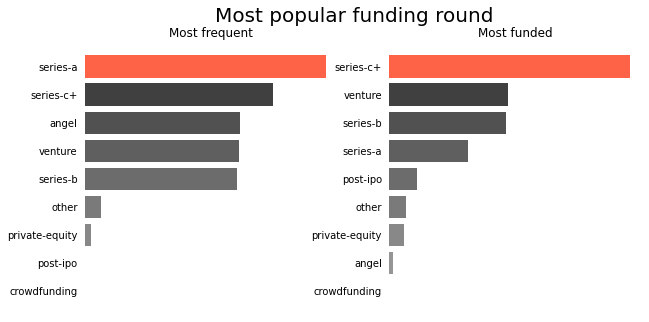

In [40]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : True,
      "ytick.left" : False}
plt.rcParams.update(rc)

plt.suptitle('Most popular funding round', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

cmap = plt.get_cmap('Greys')
colors = list(cmap(np.linspace(0.45, 0.85, len(freq_round))))

colors[8] = 'tomato'

ax1.barh(width=freq_round['frequency'].sort_values(),
        y=['crowdfunding', 'post-ipo', 'private-equity', 'other', 
            'series-b', 'venture', 'angel', 'series-c+','series-a'],
        color=colors,
        label=['crowdfunding', 'post-ipo', 'private-equity', 'other', 
            'series-b', 'venture', 'angel', 'series-c+','series-a'])

ax1.title.set_text('Most frequent')

ax2.barh(width=more_round['raised_amount'].sort_values(),
         y=['crowdfunding', 'angel', 'private-equity', 'other', 'post-ipo',
            'series-a', 'series-b', 'venture', 'series-c+'],
         color=colors,
         label=['crowdfunding', 'angel', 'private-equity', 'other', 'post-ipo',
            'series-a', 'series-b', 'venture', 'series-c+'])

ax2.title.set_text('Most funded')

plt.show()

In [41]:
conn.close()